# RGB to GrayScale

Getting started with CUDA fro Python beginners:
- [Colab Notebook](https://colab.research.google.com/drive/180uk6frvMBeT4tywhhYXmz3PJaCIA_uk#scrollTo=b50d0c42-ff5b-45c8-9945-4259482c7b6b)

- [Youtube Video](https://youtu.be/nOxKexn3iBo?si=HDlS-icrMe9GFhFX)

## Setup

In [1]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'

In [2]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

In [3]:
path_image = Path("puppy.jpg")
if not path_image.exists(): urlretrieve(url, path_image)

In [4]:
img = io.read_image("puppy.jpg")
print(img.shape)
img[:2, :3, :4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

In [5]:
def show_img(x, figsize=(4,3), **kwargs):
  plt.figure(figsize=figsize)
  plt.axis("off")
  if len(x.shape)==3: x=x.permute(1,2,0)
  plt.imshow(x.cpu(), **kwargs)

In [6]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 225, 33750)

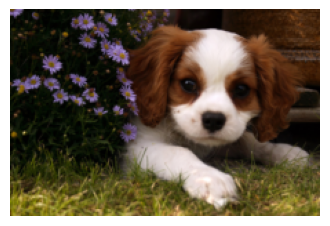

In [7]:
show_img(img2)

## Basic Python

In [8]:
def rgb2g_py(x):
  ch,h,w = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n , dtype=x.dtype, device=x.device)
  for i in range(n): res[i] = 0.2989*x[i] +  0.5870*x[i+n] +  0.1140*x[i+2*n]
  return res.view(h,w)

In [9]:
%%time
img_g = rgb2g_py(img2)

CPU times: user 1.88 s, sys: 17.2 ms, total: 1.9 s
Wall time: 1.99 s


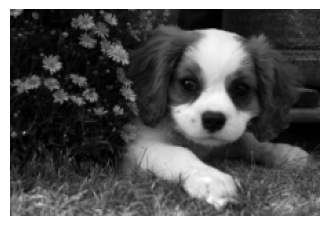

In [10]:
show_img(img_g, cmap='gray')

## Python Kernel

In [11]:
def run_kernel(f, times, *args):
  for i in range(times): f(i, *args)

In [12]:
def rgb2g_k(i, x, out, n):
  out[i] = 0.2989*x[i] +  0.5870*x[i+n] +  0.1140*x[i+2*n]

In [13]:
def rgb2g_pyk(x):
  ch,h,w = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)
  run_kernel(rgb2g_k, h*w, x, res, n)
  return res.view(h,w)

CPU times: user 2 s, sys: 19 ms, total: 2.01 s
Wall time: 2.33 s


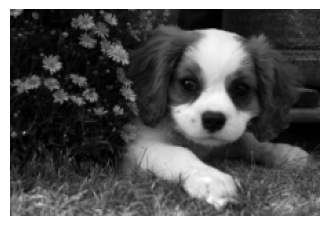

In [14]:
%%time
img_g = rgb2g_pyk(img2)
show_img(img_g, cmap='gray')

## Python Block Kernel

In [15]:
def blk_kernel(f, blocks, threads, *args):
  for i in range(blocks):
    for j in range(threads): f(i, j, threads, *args)

In [16]:
def rgb2g_bk(blockIdx, threadIdx, blockDimx, x, out, n):
  i = blockIdx*blockDimx + threadIdx
  if (i<n): out[i] = 0.2989*x[i] +  0.5870*x[i+n] +  0.1140*x[i+2*n]

In [17]:
def rgb2g_pybk(x):
  ch,h,w = x.shape
  n = h*w
  x = x.flatten()
  res = torch.empty(n, dtype=x.dtype, device=x.device)

  threads = 256
  blocks = int(math.ceil(h*w/threads))

  blk_kernel(rgb2g_bk, blocks, threads, x, res, n)
  return res.view(h,w)

CPU times: user 1.47 s, sys: 32.8 ms, total: 1.5 s
Wall time: 1.48 s


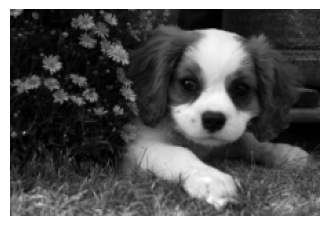

In [18]:
%%time
img_g = rgb2g_pybk(img2)
show_img(img_g, cmap='gray')

## CUDA Setup

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [20]:
%pip install -q wurlitzer ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 16.1 MB/s eta 0:00:00


In [21]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [22]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

## CUDA Kernel

In [23]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [24]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [25]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module inline_ext...


In [26]:
imgc = img.contiguous().cuda()

In [27]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 2.31 ms, sys: 43 µs, total: 2.36 ms
Wall time: 3.59 ms


(1066, 1600, 1705600)

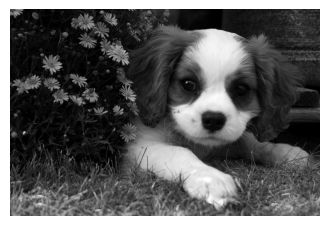

In [28]:
show_img(res, cmap='gray')